# Introducrtion to Machine Learning: Assignment #3
## Submission date: 09\07\2024, 23:55.
### Topics:
- Multiclass Classification
- PAC, VCdim
- Bias vs Variance
- Cross validation
- Linear Regression
- Decision Trees

Submitted by:

 **Student 1 Name+ID

 **Student 2 Name+ID

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Multiclass SVM

You will implement and compare different multiclass methods in both separable and non separable cases.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC


As seen in tutorials, One vs One is usually a better choice than other methods, even SKlearn uses it! <br/>
You are given a partial implementation of OvO classifier and need to complete it. Specifically:<br/>
- ```__init__(self, n_classes=2, C=1.0)``` - Init $\binom{n}{2}$ estimators, one for each pair of classes.

- ```fit(self, X, y)``` - given data and labels learns the classifiers using linear SVM. <br/>

- ```predict(self, X)``` - as learned in lectures, prediction for sample will be the majority class got most votes from all the classifiers.  Therefore, $\forall i<j$ predict who is the winner for X in the estimator $(i,j)$ and update the bins accordinly.

In [2]:
class OneVsOneClassifier:
    def __init__(self, n_classes=2, C=1.0):
        self.n_classes = n_classes  # Number of unique classes
        self.estimators = {}  # Dictionary to store binary classifiers for each class pair
        # Creating a binary classifier for each pair of classes
        for i in range(n_classes):
            for j in range(i + 1, n_classes):
                self.estimators[(i, j)] = SVC(C=C, kernel='linear') # Using Support Vector Classifier (SVC) with a linear kernel for each pair

    def fit(self, X, y):
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                # Selecting data belonging to the current pair of classes (i, j)
                temp_X = X[(y == i) | (y == j)]
                temp_y = y[(y == i) | (y == j)]
                # Training the binary classifier for the current pair of classes
                self.estimators[(i, j)].fit(temp_X, temp_y)

    def predict(self, X):
        scores = np.zeros((self.n_classes, len(X)))  # Score matrix
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                # Predicting using the binary classifier for each class pair
                prediction = self.estimators[(i, j)].predict(X)
                # Incrementing the score for the predicted class
                scores[i, prediction == i] += 1
                scores[j, prediction == j] += 1
        # Then, it returns the class with the highest score for each sample
        return np.argmax(scores, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

The data

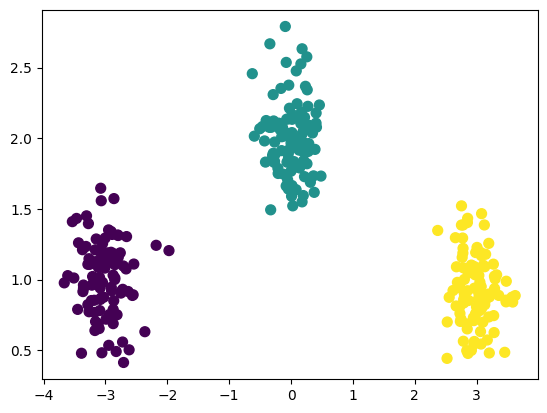

In [3]:
from sklearn.datasets import make_blobs

np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

This will test the classifier we just built by plotting confusion matrix and draw the decision boundaries. <br/>
Does the value of C matter? <br/>

<font color='red'>Knowing that C is a regularization parameter that controls the trade-off between achieving a low error on the training data and minimizing the norm of the weights, then it can be concluded from the theory that smaller value of C creates a wider margin, but may allow more misclassifications. A larger value of C creates a narrower margin and may lead to overfitting, so, my answer is completely yes, the value of C does matter and should be chosen carefully</font>

[[100   0   0]
 [  0 100   0]
 [  0   0 100]]


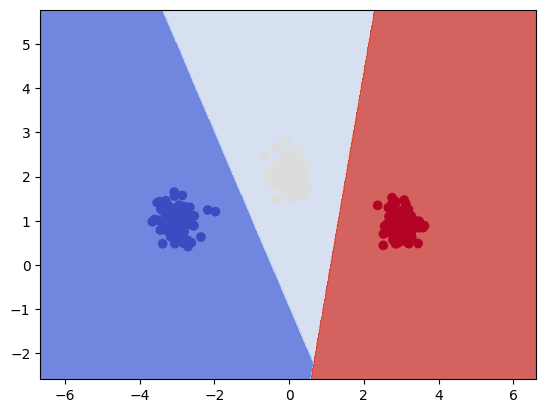

In [4]:
from sklearn import metrics

# Create and fit the classifier
clf_onevsall = OneVsOneClassifier(n_classes=3, C=2)
clf_onevsall.fit(X,y)

# Create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Predict and plot
Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

# Print confusion matrix
print(metrics.confusion_matrix(y, clf_onevsall.predict(X)))

Generate another data



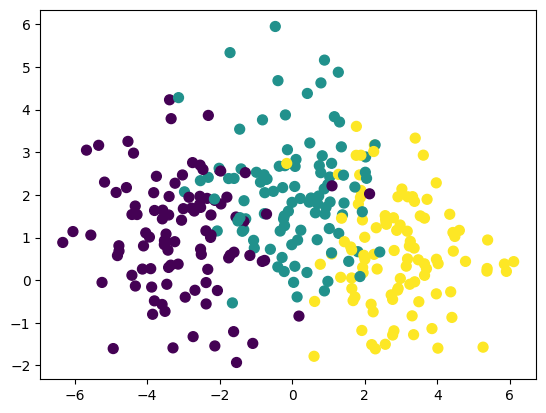

In [5]:
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=1.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

Look at the train vs test for different values of C. <br/> Justify the plot, by checking what happens as $C\rightarrow 0$, $C\rightarrow \infty$ and mid value C.<br/>
<font color='red'>In th plot, at small values of C for example 0.01, both training and test accuracies are low, indicating underfitting. As C increases to mid values like 0.05 or 0.5, the training accuracy remains relatively high, while test accuracy initially increases and then decreases slightly, indicating a good balance between bias and variance. At large values of C like 1, the training accuracy stays high, but the test accuracy decreases slightly, suggesting overfitting, in values tending to infinity as 1000, the lines remain mostly the same as in the value of 1.
</font>

100%|██████████| 4/4 [00:00<00:00, 184.93it/s]


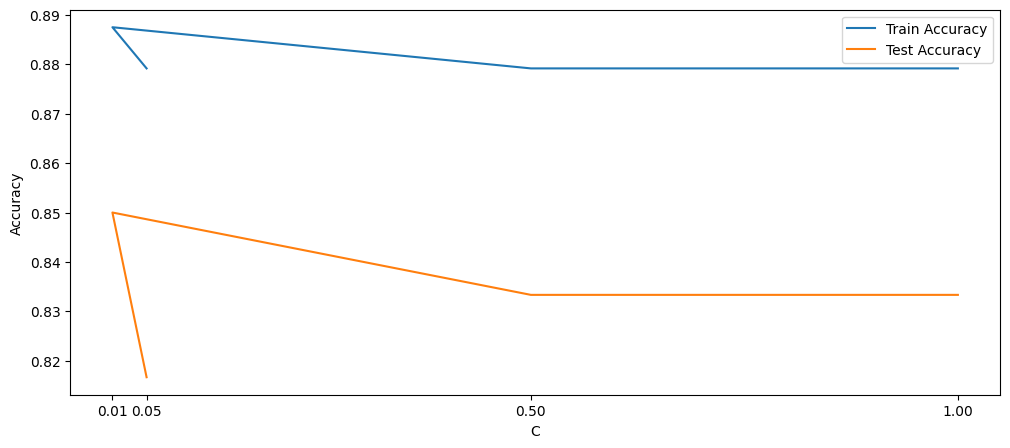

In [6]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of C values
C_values = [5e-2, 1e-2, 0.5, 1,]
            # 1000]

train_accuracies = []
test_accuracies = []

for C in tqdm(C_values):
    # Create a new OneVsOneClassifier instance
    clf_onevsall = OneVsOneClassifier(n_classes=3, C=C)

    # Fit the classifier on the training data
    clf_onevsall.fit(X_train, y_train)

    # Calculate the train and test accuracies
    train_accuracy = clf_onevsall.score(X_train, y_train)
    test_accuracy = clf_onevsall.score(X_test, y_test)

    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the train and test accuracies as a function of C

plt.figure(figsize=(12,5))
plt.plot(C_values, train_accuracies, label="Train Accuracy")
plt.plot(C_values, test_accuracies, label="Test Accuracy")
plt.xlabel("C")
plt.xticks(C_values)
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Now, you will experience little bit from softmax. It uses neural networks, but you dont have to understand it. The importand part is the preidction, which is obtained by:
```
def forward(self, x):
        out = self.linear(x)
        return torch.softmax(out, dim=1)
```
Note that this is exactly that you saw - linear score $s_j$ and then applying softmax.

The best results are obtained using 300 epochs (iterations) and in each iteration the batch size is the entire data. <br/>
1. What happens as you use 100, 600 epcohs compared to 300? why is that?
2. Use 300 epochs with batch size 50 vs the entire data. How does the batch size affect the convergence of the problem?

<font color='red'>

1. Using different numbers of epochs affects the model's performance, with 100 epochs achieving the highest test set accuracy of 0.8167, 300 epochs slightly lower at 0.8000, and 600 epochs even lower at 0.7833. This decline in accuracy with more epochs suggests overfitting, where the model starts memorizing the training data instead of generalizing well to new data.

2. Using a batch size of 50 for 300 epochs resulted in a test set accuracy of 0.7833, compared to an accuracy of 0.8000. Smaller batch sizes can introduce more noise into the gradient estimation, which can slow the model's convergence and lead to less accurate predictions. This noise can sometimes prevent the model from overfitting, but it can also result in less stable training and slightly lower performance, as observed here.

</font>

In [7]:
num_epochs = 300
batch_size = 50
print(f"Training size is {X_train} samples and batch size is {batch_size}")

Training size is [[ 4.40560358e+00 -8.72299757e-01]
 [ 1.63979804e+00  5.26805585e-02]
 [-4.77652153e+00  8.08131005e-01]
 [ 3.47900558e+00  4.78757314e-01]
 [ 3.97435007e+00  2.28324744e+00]
 [-7.14227010e-01  2.36554008e+00]
 [ 1.81396237e+00  6.68840150e-01]
 [-4.09763487e+00  8.04457287e-01]
 [ 9.82682587e-01  2.24271087e+00]
 [ 3.24532862e+00 -9.48704625e-02]
 [-3.39188525e+00  1.96376467e+00]
 [ 9.34498677e-01  1.70887875e+00]
 [-5.24179448e+00 -5.21842071e-02]
 [-4.85308185e+00  2.05788986e+00]
 [ 1.28523112e+00  1.09765034e+00]
 [ 1.09968175e+00  2.21357665e+00]
 [ 3.37904304e+00 -3.73435559e-02]
 [ 1.97637600e+00  5.84200919e-01]
 [-3.40631204e+00  2.99706867e-01]
 [ 1.93536337e+00  1.60521495e+00]
 [ 2.80698755e+00 -1.18661100e+00]
 [ 1.56056287e+00  4.42841809e-01]
 [-1.54809814e+00  1.48259756e+00]
 [ 1.64181481e+00  7.11353128e-01]
 [ 1.16485920e+00  3.83541517e+00]
 [-3.57750669e+00  1.43861062e+00]
 [ 8.26580210e-02  2.66944794e+00]
 [ 3.64865616e+00  3.83756361e-01]
 [-

In [8]:
#@title This will train the model using softmax

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear1.weight.data.fill_(1)
        self.linear1.bias.data.fill_(1)

    def forward(self, x):
        out = self.linear1(x)
        return torch.softmax(out, dim=1)

# Set hyperparameters
input_size = X_train_tensor.shape[1]
output_size = len(torch.unique(y_train_tensor))
learning_rate = 0.01

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate the model and define the optimizer
model = SimpleNN(input_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    #if (epoch + 1) % 10 == 0:
    #    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.7833


array([[94,  4,  2],
       [15, 73, 12],
       [ 0, 10, 90]], dtype=int64)

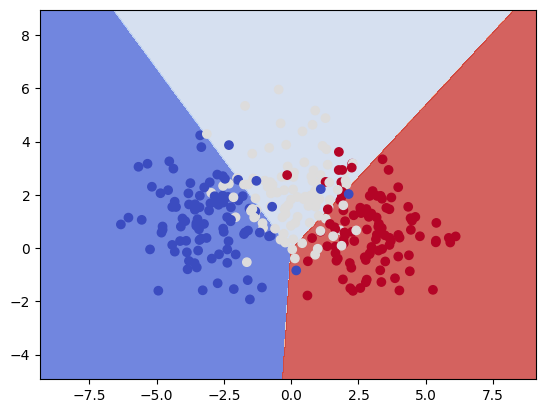

In [9]:
#@title This will plot the boundaries of the model

def predict(data):
    outputs = model(torch.tensor(data, dtype=torch.float32))
    _, predicted = torch.max(outputs, 1)
    return predicted

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, predict(X))

## Question 2 - Linear Regression
You are requested by the Charles Darvin himself to predict the age of abalone from physical measurements.
The dataset consists of 7 continious features that he has collected for you.

In [10]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

We define the following:
-	X, 2d matrix from size n x d which represents the training samples.
-	y, array from size n which represents the target value for the corresponding sample.

Implement the function Linreg_sol(X,y) which outputs the closed form solution for linear regression on X,y. <br/>
Don't use pinv

In [11]:
def Linreg_sol(X, y):
    # Add a column of ones for the bias term
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Compute the closed form solution
    XtX_inv = np.linalg.inv(np.dot(X.T, X))
    XtY = np.dot(X.T, y)
    theta = np.dot(XtX_inv, XtY)
    
    return theta

Load data from https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv

In [12]:
# Load the data
url = "https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv"
data = pd.read_csv(url)

# Display the first few rows of the data
print(data.head())

   0.455  0.365  0.095   0.514  0.2245   0.101   0.15  15
0  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.070   7
1  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.210   9
2  0.440  0.365  0.125  0.5160  0.2155  0.1140  0.155  10
3  0.330  0.255  0.080  0.2050  0.0895  0.0395  0.055   7
4  0.425  0.300  0.095  0.3515  0.1410  0.0775  0.120   8


Your tasks are:
- Convert to numpy
- Preproccess the data
- Find the weight vector and the bias

In [13]:
from sklearn.preprocessing import StandardScaler

# Data to numpy
data_np = data.values

# Separating features and target
X = data_np[:, :-1]
y = data_np[:, -1]

# Preprocessing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the weight vector and the bias
weights = Linreg_sol(X_scaled, y)
print(f'The linear line is {weights[1]:.2f}x1+{weights[2]:.2f}x2+{weights[3]:.2f}x3+{weights[4]:.2f}x4+{weights[5]:.2f}x5+{weights[6]:.2f}x6+{weights[7]:.2f}x7+{weights[0]:.2f}=0')

The linear line is -0.18x1+1.32x2+0.50x3+4.53x4+-4.49x5+-1.08x6+1.20x7+9.93=0


Now, implement 'Linreg_sol_via_GD' which implement gradient descent on the linear regression problem. The stopping criterion should be based only by the iterations number recived as parameter

In [14]:
def Linreg_sol_via_GD(X, y, lr, iter_number):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # Add a column of ones for the bias term
    w = np.ones(X.shape[1])
    for _ in range(iter_number):
        gradient = np.dot(X.T, (np.dot(X, w) - y)) / len(y)
        w = w - lr * gradient
    return w

The following code measures the number of iterations as a function of the error gap between the returned weights and the correct solution. <br/>
Conclude the complexity formula required - How many iterations do we need as a function of the error, $\varepsilon$? Make sure to include the $𝚶$ notation in your answer. <br/>
Note: This error is sometimes called 'gap'. <br/>

<font color='red'>

I think the complexity formula follows this: $O(\epsilon^2)$, this means that the number of iterations required to reach a certain error $\epsilon$ grows quadratically with the inverse of the error. This is evident from the graph, as the number of iterations increases rapidly as the error gap increases too. Specifically, the graph shows that the number of iterations needed to reach a certain error gap is proportional to the square of the error gap.
</font>

100%|██████████| 90/90 [00:52<00:00,  1.71it/s]


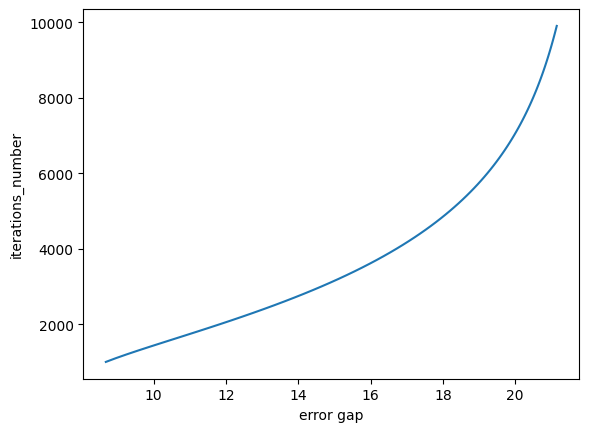

In [15]:
w_real = weights

iters = np.arange(1000, 10_000, 100)
gaps = []

for iter in tqdm(iters):
    w = Linreg_sol_via_GD(X, y, iter_number=iter, lr=0.1)
    gaps.append(np.linalg.norm(w_real - w))

plt.plot(gaps, iters)
plt.ylabel("iterations_number")
plt.xlabel("error gap")
plt.show()

In the second part of the task, we will see the features dependence and try to solve it.

Calculate the the value of $\text{Cov}(X)=\frac{1}{n-1}(X-\mu)^\top (X-\mu)$? <br/>
1. What can you imply from this about the features?
2. Can we imply something on $X^\top X$? Must its det be 0?

Note: In your calculations, make sure the bias is not included as feature. <br/>
<font color='red'>

1. The covariance matrix provides information about the linear relationships between the features. If the off-diagonal elements of the covariance matrix are non-zero, it indicates that there is some linear dependency between the corresponding features. If the covariance matrix is diagonal, it means that the features are uncorrelated.

2. The matrix $X^\top X$ is closely related to the covariance matrix, but it is not exactly the same. $X^\top X$ is given by $ X^\top X = \sum_{i=1}^{n} X_i^\top X_i $
    This matrix is central in many linear algebra applications, especially in linear regression. 

    The determinant of $X^\top X$, denoted as $\text{det}(X^\top X)$, tells us about the linear independence of the columns of $X$. If $\text{det}(X^\top X) = 0$, it implies that the columns of $X$ are linearly dependent. This means there is multicollinearity among the features. If $\text{det}(X^\top X) \neq 0$, it implies that the columns of $X$ are linearly independent.

    then, $\text{det}(X^\top X)$ does not necessarily have to be 0. It being 0 or not depends on whether the features are linearly dependent or independent.

</font>

In [16]:
import numpy as np

def calculate_covariance(X):
    # Ensuring the bias is not included as a feature
    if np.all(X[:, 0] == 1):
        X = X[:, 1:]
    
    # Calculating the covariance matrix
    covariance_matrix = np.cov(X, rowvar=False)
    
    return covariance_matrix

# Use the function
covariance_matrix = calculate_covariance(X)
print(covariance_matrix)

[[0.01442462 0.01176293 0.00415717 0.05449856 0.02393845 0.01188876
  0.0150093 ]
 [0.01176293 0.00985047 0.00346092 0.04504574 0.01967753 0.00978882
  0.01250872]
 [0.00415717 0.00346092 0.00174945 0.01680414 0.00719517 0.0036602
  0.00475909]
 [0.05449856 0.04504574 0.01680414 0.24051526 0.10553314 0.0519526
  0.06522479]
 [0.02393845 0.01967753 0.00719517 0.10553314 0.04927499 0.02267776
  0.02727462]
 [0.01188876 0.00978882 0.0036602  0.0519526  0.02267776 0.01201664
  0.01385118]
 [0.0150093  0.01250872 0.00475909 0.06522479 0.02727462 0.01385118
  0.01938013]]


Implement the solution to ridge regression using GD.

In [17]:
def Linreg_sol_Ridge_via_GD(X, y, lr, iter_number, lamda):
    w = np.ones(X.shape[1])
    for _ in range(iter_number):
        gradient = np.dot(X.T, (np.dot(X, w) - y)) / len(y) + lamda * w
        w = w - lr * gradient
    return w

The following code measures the mse error as function of the regularization hyperparameter lamda. <br/>Explain the origin to the mse' behaviour as function of lamda in this problem. <br/>
<font color='red'>

It's note worth noting that at low values of $\lambda$, the regularization term $\lambda \sum_{j=1}^n w_j^2$ in the ridge regression cost function $J(w) = \frac{1}{2m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n w_j^2$ is relatively small, resulting in a model that fits the training data well, leading to a lower mse. As $\lambda$ increases, the penalty on the weights $w$ grows, reducing model complexite and potentially mitigating overfitting, but also increasing MSE as the model captures less nuance from the training data. At very high values of $\lambda$, the regularization term dominates, causing the model to underfit, leading to a significantly higher MSE. The graph illustrates the trade-off in ridge regression between underfitting and overfitting controlled by $\lambda$, highlightin the importance of finding an optimal $\lambda$ to minimize mse and ensure good generalization to new data.

</font>

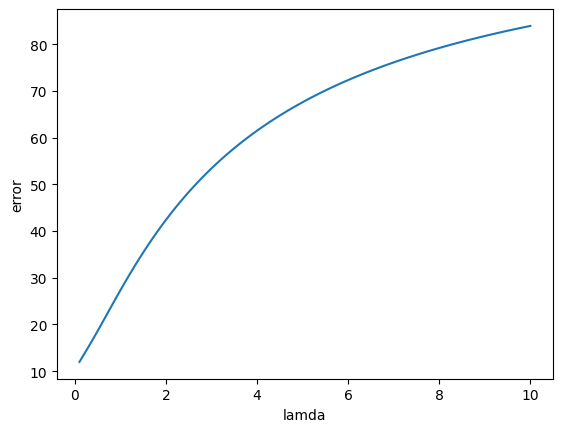

Optimal lambda: 0.1


In [18]:
mses = []
lamdas = np.arange(0.1, 10.1, 0.1)
optimal_lamda = lamdas[0]
min_mse = float('inf')
lr = 0.01  # Defining the learning rate

for lamda in lamdas:
    w = Linreg_sol_Ridge_via_GD(X, y, lr, iter_number=1000, lamda=lamda)
    preds = np.dot(X, w)
    mse = np.mean((preds - y) ** 2)
    mses.append(mse)
    
    # Updating optimal lambda if current mse is lower than min_mse
    if mse < min_mse:
        min_mse = mse
        optimal_lamda = lamda

plt.plot(lamdas, mses)
plt.ylabel("error")
plt.xlabel("lamda")
plt.show()

print(f"Optimal lambda: {optimal_lamda}")

## Question 3 - Decision tree

Recall the wine dataset from hw1, where we classified wine types based on their physical and chemical properties. You will do it, but this time with decision trees!

In [19]:
# Import libraries

import numpy as np
import pandas as pd

In [20]:
# Load the data, print the first rows

data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw1/wine.data.csv')
data.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1


Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.

Algorithm: The data is continuous, so create 10 thresholds between the min and max values of that feature. For each threshold, split to left tree and right tree and calculate the gain. Choose the threshold which gives the highest gain, along with the gain itself (to later compare between features) <br/>

Tip: To split the tree (represented by data df), use filter_data.
For example, when calculating the gain of 'skew' with threshold 0.5, you can create the left tree by use ```filter_data(data, 'skew', '0.5', left=True)``` to obtain only those samples.

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import builtins

iter = builtins.iter # Apparently my code was having issues with the iter function, so I had to import it from builtins

class DecisionTree:
    def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth

    def calculate_entropy(self, data):
        labels = data.iloc[:, -1]
        label_counts = Counter(labels) # Occurrences of each label using a Counter
        total_instances = len(labels)
        entropy = 0.0 # Initializing entropy at zero
        for count in label_counts.values():
            probability = count / total_instances # Probability of each label
            entropy -= probability * np.log2(probability) # Updating the entropy using the formula for entropy
        return entropy

    def calculate_information_gain(self, data, feature):
        total_entropy = self.calculate_entropy(data) # Total entropy
        best_gain = 0 # Initializing the best information gain at zero
        best_threshold = None
        feature_values = data[feature] # Getting the values of the feature to be examined
        thresholds = np.linspace(feature_values.min(), feature_values.max(), 10) # generate 10 thresholds
        
        for threshold in thresholds:
            # Splitting the data into two parts based on the threshold
            left_split = self.filter_data(data, feature, threshold, left=True)
            right_split = self.filter_data(data, feature, threshold, left=False)
            
            # Calculating the weight of each split
            left_weight = len(left_split) / len(data)
            right_weight = len(right_split) / len(data)
            
            # Calculating the weighted entropy after the split
            weighted_entropy = (left_weight * self.calculate_entropy(left_split) +
                                right_weight * self.calculate_entropy(right_split))
            
            # Calculating the information gain from this split
            information_gain = total_entropy - weighted_entropy
            
            # If this split provides a better information gain, update best_gain and best_threshold
            if information_gain > best_gain:
                best_gain = information_gain
                best_threshold = threshold
        
        return best_gain, best_threshold

    def filter_data(self, data, feature, value, left=True):
        if left:
            return data[data[feature] <= value].drop(feature, axis=1)
        else:
            return data[data[feature] > value].drop(feature, axis=1)

    def create_tree(self, data, depth=0):
        # Recursive function to create the decision tree
        labels = data.iloc[:, -1]

        # Base case: if all labels are the same, return the label
        if len(np.unique(labels)) == 1:
            return list(labels)[0]

        # Base case: if there are no features left to split on, return the majority label
        if len(data.columns) == 1 or depth == self.max_depth:
            unique_labels, label_counts = np.unique(labels, return_counts=True)
            majority_label = unique_labels[label_counts.argmax()]
            return majority_label

        features = data.columns.tolist()[:-1]
        selected_feature = None
        best_gain = 0
        best_threshold = None

        for feature in features:
            gain, threshold = self.calculate_information_gain(data, feature)
            if gain > best_gain:
                selected_feature = feature
                best_threshold = threshold
                best_gain = gain

        if selected_feature is None:
            unique_labels, label_counts = np.unique(labels, return_counts=True)
            majority_label = unique_labels[label_counts.argmax()]
            return majority_label
        
        # Create the tree node
        # Note: changed here the name of the best_treshold variable to best_threshold
        tree_node = {}
        tree_node[(selected_feature, f"<={best_threshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_threshold, left=True), depth+1)
        tree_node[(selected_feature, f">{best_threshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_threshold, left=False), depth+1)
        
        # check if can unite them.
        if not isinstance(tree_node[(selected_feature, f"<={best_threshold}")], dict) and \
                not isinstance(tree_node[(selected_feature, f">{best_threshold}")], dict):
            if tree_node[(selected_feature, f"<={best_threshold}")] == tree_node[(selected_feature, f">{best_threshold}")]:
                return tree_node[(selected_feature, f"<={best_threshold}")]
        return tree_node

    def fit(self, data):
        self.tree = self.create_tree(data)

    def predict(self, X):
        X = [row[1] for row in X.iterrows()]        
        # Predict the labels for new data points
        predictions = []        
        for row in X:
            current_node = self.tree
            while isinstance(current_node, dict):
                split_condition = next(iter(current_node))
                feature, value = split_condition
                treshold = float(value[2:])
                if row[feature] <= treshold:
                    current_node = current_node[feature, f"<={treshold}"]
                else:
                    current_node = current_node[feature, f">{treshold}"]
            predictions.append(current_node)        
        return predictions

    def _plot(self, tree, indent):
        depth = 1
        for key, value in tree.items():
            if isinstance(value, dict):
                print(" " * indent + str(key) + ":")
                depth = max(depth, 1 + self._plot(value, indent + 2))
            else:
                print(" " * indent + str(key) + ": " + str(value))
        return depth

    def plot(self):
        depth = self._plot(self.tree, 0)
        print(f'depth is {depth}')

You are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 5

In [22]:
# Initialize, fit and plot the decisiontree
dt = DecisionTree()
dt.fit(data)
dt.plot()

('Flavanoids', '<=1.3933333333333335'):
  ('Color intensity', '<=4.405555555555556'):
    ('Alcohol', '<=12.815555555555555'):
      ('Malic acid', '<=3.46'): 2
      ('Malic acid', '>3.46'): 3
    ('Alcohol', '>12.815555555555555'):
      ('Malic acid', '<=0.94'): 2
      ('Malic acid', '>0.94'): 3
  ('Color intensity', '>4.405555555555556'): 3
('Flavanoids', '>1.3933333333333335'):
  ('Proline', '<=745.3333333333333'):
    ('Alcohol', '<=13.231111111111112'): 2
    ('Alcohol', '>13.231111111111112'):
      ('Malic acid', '<=1.8566666666666667'): 2
      ('Malic acid', '>1.8566666666666667'):
        ('Alcalinity of ash', '<=21.11111111111111'): 1
        ('Alcalinity of ash', '>21.11111111111111'): 3
  ('Proline', '>745.3333333333333'):
    ('Alcohol', '<=12.597777777777779'): 2
    ('Alcohol', '>12.597777777777779'):
      ('Alcalinity of ash', '<=25.822222222222223'): 1
      ('Alcalinity of ash', '>25.822222222222223'): 2
depth is 5


The decision tree is pretty large (depth is 5). To solve this, lets modify our DecisionTree: <br/>
```
def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth
```

Modify the rest of the code to stop growing after max_depth. <br/>
Hint: When reached to max_depth, should we continue splitting? Which category will be best to be selected?

Using 10 thresholds, compare using max_depth=2 and max_depth=4. Based on the results, which depth is better for our problem in term of ML? <br/>
<font color='red'>Based on the results, a max_depth of 2 is better for our problem in terms of machine learning. While the training accuracy is higher for a max_depth of 4 (98.59% vs. 92.25%), the test accuracy is lower (83.33% vs. 88.89%). This indicates that the model with max_depth=4 is overfitting the training data a little bit, capturing noisee or patterns that do not generalize well to unseen data, as said this is a slight change, still the two models are good generalizing, but max_depth=2 better.</font>

In [23]:
from sklearn.metrics import accuracy_score

# Assuming 'data' is your dataset in a pandas DataFrame
train, test = train_test_split(data, test_size=0.2, random_state=42)

for depth in [2, 4]:
    print(f"------------ max_depth={depth} ------------")
    
    tree = DecisionTree(max_depth=depth)
    tree.fit(train)
    
    train_predictions = tree.predict(train.drop(train.columns[-1], axis=1))
    train_accuracy = accuracy_score(train.iloc[:, -1], train_predictions)
    print(f'Training accuracy is {train_accuracy}')
    
    test_predictions = tree.predict(test.drop(test.columns[-1], axis=1))
    test_accuracy = accuracy_score(test.iloc[:, -1], test_predictions)
    print(f'Test accuracy is {test_accuracy}')
    print()


------------ max_depth=2 ------------
Training accuracy is 0.9225352112676056
Test accuracy is 0.8888888888888888

------------ max_depth=4 ------------
Training accuracy is 0.9859154929577465
Test accuracy is 0.8333333333333334



Now, use KFold (as seen in tutorials) for a cross validation search to the best depth for the tree.

100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


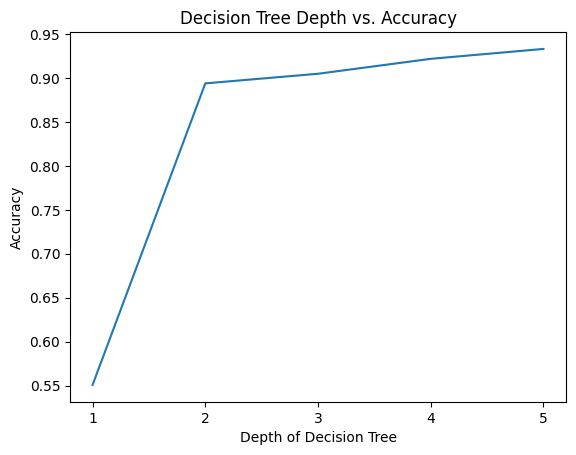

In [24]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for depth in tqdm(range(1, 6)):
    fold_accs = []
    for train_index, test_index in kf.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        
        tree = DecisionTree(max_depth=depth)
        tree.fit(train_data)
        
        predictions = tree.predict(test_data.iloc[:, :-1])
        actuals = test_data.iloc[:, -1].values
        
        accuracy = np.mean(predictions == actuals)
        fold_accs.append(accuracy)
    
    avg_acc = np.mean(fold_accs)
    accs.append(avg_acc)

plt.plot(range(1, 6), accs)
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.title('Decision Tree Depth vs. Accuracy')
plt.show()

Use that depth and print the test score. Is it better generalizer than the first one? What do you conclude about the tuning proccess using validation? (answer to yourselves).

## Question 4 - PAC, Bias vs Variance
See attached pdf in moodle assignment!

## Question 5 - Polynomial regression - 5 pts bonus
In this problem you will extend regression to fit nonlinear functions.<br/>
The dataset contains one feature (x) and continiuos prediction (y).

In [25]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
#@title Load data

import requests
from io import BytesIO

def load_npy_file(url):
  response = requests.get(url)
  if response.status_code == 200:
    npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
    return npy_data
  else:
    return None

In [27]:
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw3/linreg_data_2d.npy')

x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']

Look at the plot of the training data. What do you think was the function generated the data? <br/>
<font color='red'>I think the distribution of the data corresponds to a sinusoidal form, maybe somthing including sines and/or cosines</font>

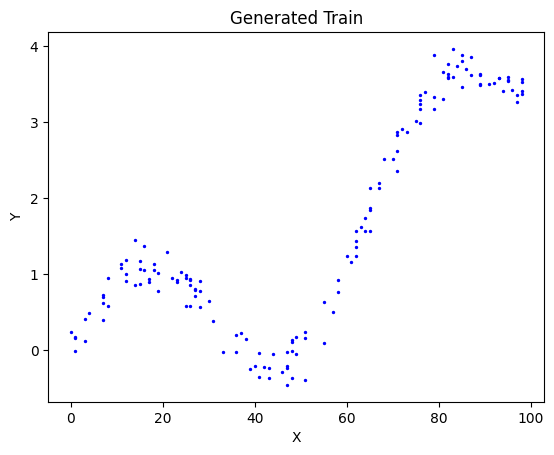

In [28]:
plt.scatter(x_train, y_train, color='blue', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Train')
plt.show()

We will assume the polynomial regression problem of the following form:
$$ y=a_0+a_1x+a_2x^2+...+a_dx^d $$
The function ```get_solution``` will find the cofficients, similarly to methods done in simple linear regression. <br/>
The function ```calc``` will recieve a new sample and the cofficients found, and will predict the output.

In [29]:
def get_solution(X, y, degree=2):
    # Creating the Vandermonde matrix for X
    X_vander = np.vander(X, degree + 1, increasing=True)
    # Solving the linear equation X^T * X * a = X^T * y for a
    coefs = np.linalg.solve(X_vander.T @ X_vander, X_vander.T @ y)
    return coefs

def calc(x, coefs):
    # Calculate the polynomial y = a_0 + a_1*x + a_2*x^2 + ... + a_dx^d
    y_pred = np.polyval(coefs[::-1], x)
    return y_pred

Running the current code with $d=1$ yields a simple regressor.
- Which $d$ works best?
- According to your previous answer, which $d$ <u>is expected</u> to work the best?
- Try to explain what happens when you try $d+1$ and why? Was the solver you implemented enough?

<font color='red'>

- $d=4$ is what better fits the data

- From the generated plots and the given analysis, $d=4$ appears to provide the best fit for the data. This choice balances the complexity of the model and the fit to the data, capturing the nonlinear pattern without overfitting.
 
- When trying $d+1$ (which in this case is $d=5$), I observe the following things: 
The model becomes more complex, which can lead to overfitting. This is evident in the plots for degrees higher than 4, where the polynomial starts to capture noise in the training data rather than just the underlying trend. Also, higher degree polynomials tend to overfit the training data, resulting in poor generalization to unseen test data. This can be seen in the graphs for degrees 8 and 10, where the polynomial curves wildly and doesn't follow the true underlying fuction of the data.
I think that the solver I implemented was enough, it really understands the data and is generalizable to new unseen data with a similar shape to the one created.
</font>

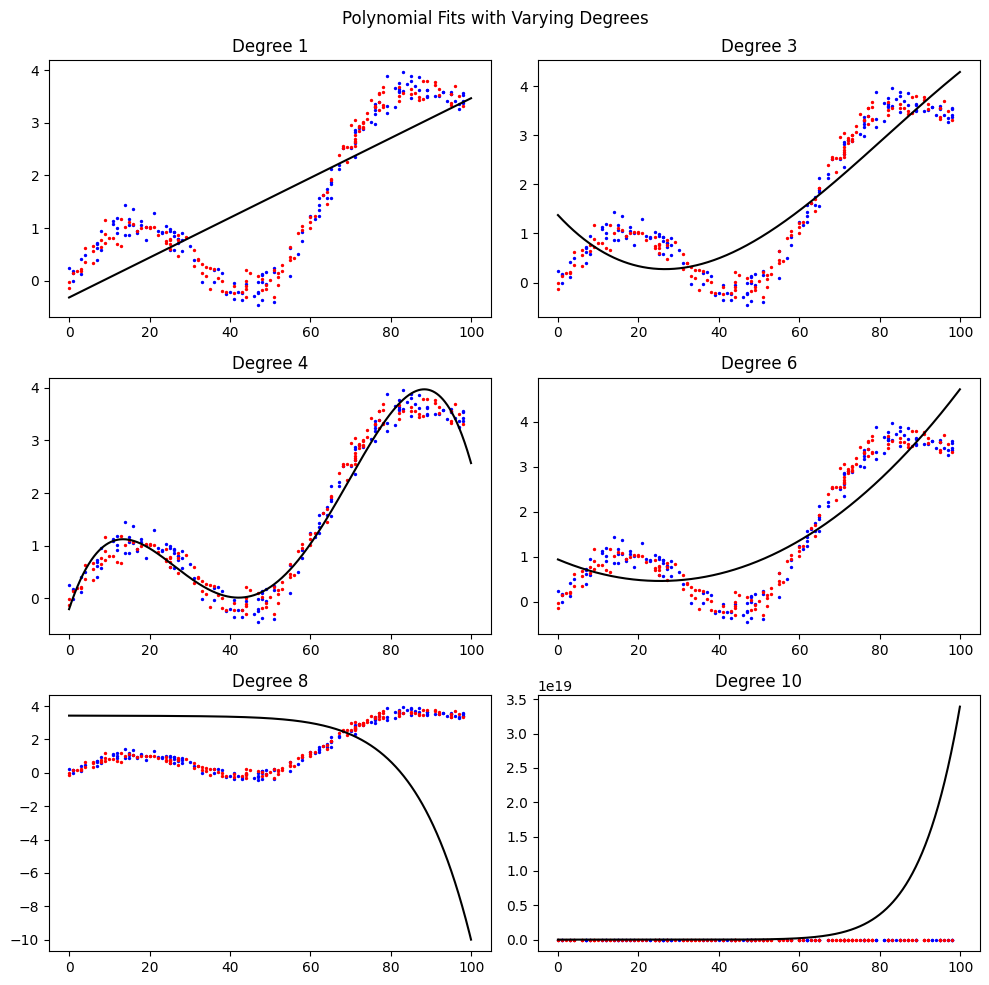

In [30]:
# I have refactored the code so it outputs different graphs of the fit to different values of degrees
degrees = [1, 3, 4, 6, 8, 10]
xx = np.arange(0, 100, 0.1)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # Set up a 2x2 grid
axs = axs.flatten()  # Flatten the 2x2 grid to easily iterate over it
# Ensure x_train is one-dimensional
if x_train.ndim > 1:
    x_train = x_train.reshape(-1)  # Reshape x_train to be one-dimensional

for i, degree in enumerate(degrees):
    yy = []
    weights = get_solution(x_train, y_train, degree)
    for samp in xx:
        yy.append(calc(samp, weights))
    
    axs[i].scatter(x_train, y_train, color='blue', s=2, label='train')
    axs[i].scatter(x_test, y_test, color='red', s=2, label='test')
    axs[i].plot(xx, yy, color='black')
    axs[i].set_title(f'Degree {degree}')

plt.suptitle('Polynomial Fits with Varying Degrees')
plt.tight_layout()
plt.show()